This is a refresher on partial differential equation and a basic implementation in python. We will be using similar techniques during IFN680, and this is a good introduction. 

We use the heat equation because it is a key equation in physics that simulates how temperature spread in a medium. It is the same equation that describes how particules spread, or diffuse, in a medium, which are also turns out to be a Gaussian process. It can be used in image processing to blurr images, often implemented as a Gaussian filter. 

Painterly effect can be implemented using this method.

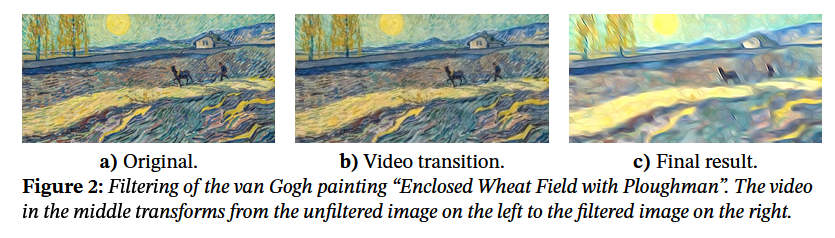

From: https://nils-olovsson.se/articles/image_smearing_by_anisotropic_diffusion/

# 1. The heat equation
The heat equation is a partial differential equation (PDE) that describes how the temperature varies in a given region over time. The general form of the heat equation in one dimension is:

$$\frac{\partial f(x,t)}{\partial t} = c \cdot \frac{\partial^2 f(x,t)}{\partial x^2}$$

Where:

- $f(x,t)$ is the temperature (or signal) at position $x$ and time $t$.
- $\frac{\partial f(x,t)}{\partial t}$  is the rate of change of temperature with respect to time at position $x$.
- $\frac{\partial^2 f(x,t)}{\partial x^2}$ is the second spatial derivative of the temperature at position xx, which describes how the slope of the temperature is changing at that point.
- $c$ is the conduction factor, which represent how quickly heat diffuses throughjj the material

The second derivative can be thought of as the composition of first derivatives:

$$\frac{\partial^2 f(x,t)}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial f(x,t)}{\partial x} \right)$$





The heat equation is a type of partial differential equation that describes how a quantity such as temperature diffuses through a medium over time. There are several other important partial differential equations in physics that have a similar form or analogous behavior. Here are a few examples:

**Schrödinger Equation**

The time-dependent Schrödinger equation is fundamental in quantum mechanics and describes how the quantum state of a physical system changes over time.

$$i\hbar \frac{\partial}{\partial t} \Psi(\mathbf{r}, t) = \hat{H} \Psi(\mathbf{r}, t)$$

Here, $\Psi(r,t)$ is the wave function, $\hat{H}$ is the Hamiltonian operator, $ℏ$ is the reduced Planck constant, and $i$ is the imaginary unit. The Hamiltonian operator often includes a term analogous to the Laplacian (second spatial derivative) in the heat equation, representing kinetic energy.


**Wave Equation**

The wave equation describes the propagation of waves, such as sound or light, through a medium.
It is given by:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u$$

Here, uu is the displacement of the wave, cc is the speed of the wave, and ∇2∇2 is the Laplacian operator, which involves second spatial derivatives.

**Diffusion Equation**

Similar to the heat equation, the diffusion equation describes how particles spread from areas of high concentration to low concentration.

\frac{\partial \phi}{\partial t} = D \nabla^2 \phi

Here, ϕϕ is the concentration of the particles, and DD is the diffusion coefficient.

**Fokker-Planck Equation**

This equation describes the time evolution of the probability density function of the position and velocity of a particle undergoing diffusion in a potential.
It is used in statistical mechanics and has the form:

$$
\frac{\partial}{\partial t} f(x, v, t) = -\frac{\partial}{\partial x} [v f(x, v, t)] + \frac{\partial}{\partial v} [\gamma v f(x, v, t)] + D \frac{\partial^2}{\partial v^2} f(x, v, t)
$$

Here, f(x,v,t)f(x,v,t) is the probability density function, γγ is the damping coefficient, and DD is the diffusion coefficient.

These equations all involve derivatives with respect to time and space, illustrating how different physical quantities evolve and interact. The Schrödinger equation, in particular, is crucial for understanding quantum mechanical systems and exhibits wave-like solutions similar to those found in the wave equation.

# 2. Implementing the time derivative

To solve the heat equation numerically, we can use a simple first-order Euler method for time integration. 

Then using the spatial step dx and the time step dt, we can write the discrete derivatives:

Using $\frac{\partial f(x,t)}{\partial t} \approx \frac{f(x,t)-f(x,t-dt)}{dt}$ our equation becomes:

$$f(x,t) = f(x,t-dt) + c . dt . \frac{\partial}{\partial x} \left( \frac{\partial f(x,t)}{\partial x} \right)$$





# 3.Implementing the spatial derivatives

Similar to the above, the spatial derivative can be written:

$$ \frac{\partial f(x,t)}{\partial x} \approx \frac{f(x,t)-f(x-dx,t)}{dx}$$

Then we can implement easily the equation on a discrete grid of time and distance: we define the number of spatial points nx and the number of time steps nt, over a defined range with $t \in [0,10]$ and $x \in [0,10]$.

Text(0, 0.5, 'f(x,t)')

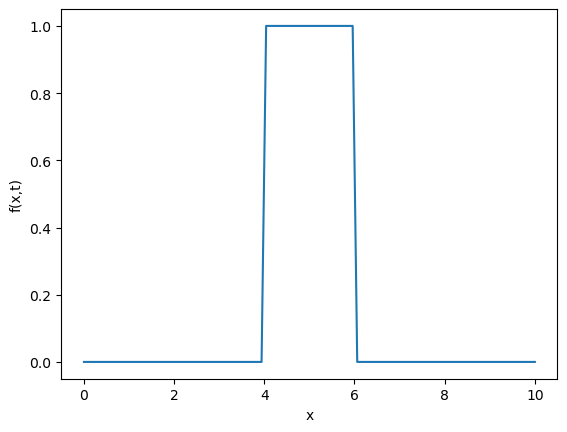

In [14]:
import torch
import matplotlib.pyplot as plt

nx = 100  # Number of spatial points
dx = 10.0 / (nx - 1)  # Spatial step size

# spatial grid from 0 to 10 with nx points
x = torch.linspace(0, 10, nx)

# we can make up a function f(x) on that grid
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1

# and visualise it
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')


Let's compute the first derivate explicitely using the indices:

$$ \frac{\partial f(x,t)}{\partial x} \approx \frac{f(x,t)-f(x-dx,t)}{dx}$$

Text(0, 0.5, 'f(x,t)')

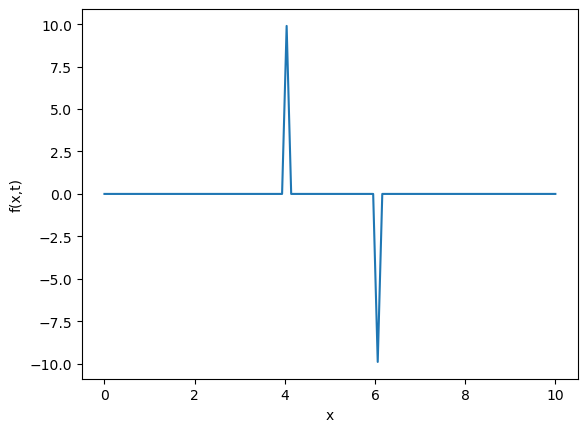

In [31]:
# first derivative
df_dx = torch.zeros(x.size())
df_dx[1:] = (f[1:] - f[:-1])/dx
# and visualise it
plt.plot(x, df_dx, label='first derivative of f')
plt.xlabel('x')
plt.ylabel('f(x,t)')

The above is equivalent to applying [-1 1] at every point. This can be done by convolving with a 1D kernel [-1 1] using pytorch

Parameter containing:
tensor([[[0.6847, 0.0099]]])
Parameter containing:
tensor([[[-1.,  1.]]])
torch.Size([1, 101])


Text(0, 0.5, 'f(x,t)')

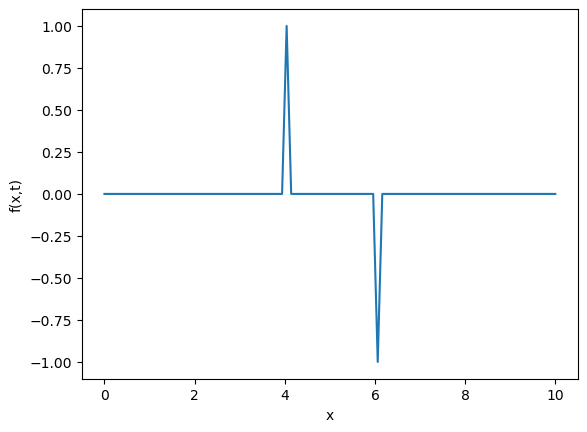

In [68]:
import torch
# first derivative convolution
der = torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=2,stride=1,padding=1,bias=None)
der.weight.requires_grad =  False # no need to optimize
# show the kernel
print(der.weight)
# replace the kernel with [-1 1]
der.weight.data = torch.tensor([[[-1.0,1.0]]])
print(der.weight)
# apply the convolution to f
df_dx = der(f[None,:])
# since there is a padding of 1, the output will have an extra sample
print(df_dx.shape)
df_dx = df_dx[0,0:-1] # remove the batch dimension and the last sample

# and visualise it
plt.plot(x, df_dx, label='first derivative of f')
plt.xlabel('x')
plt.ylabel('f(x,t)')

The second derivative can be found by convolving two first derivative kernels together:

$$[-1 \hspace{0.5cm} 1] \otimes [-1 \hspace{0.5cm} 1] = [-1 \hspace{0.5cm} 2 \hspace{0.5cm} -1] $$

## 4.Simulating the whole PDE

We can now solve the PDE iteratively and simulate a diffusion across space:

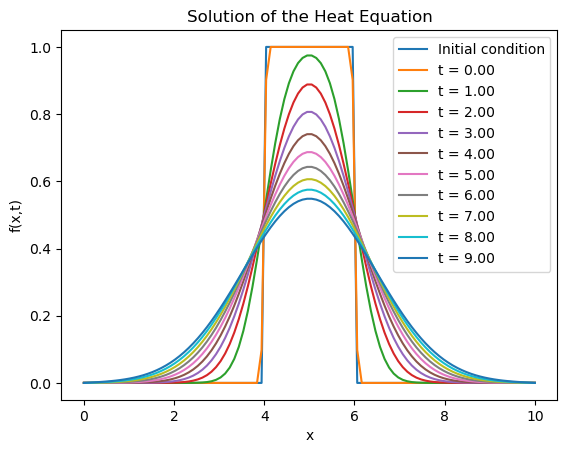

In [6]:
import torch
import matplotlib.pyplot as plt

# Parameters
nx = 100  # Number of spatial points
nt = 1000  # Number of time steps
dx = 10.0 / (nx - 1)  # Spatial step size
dt = 0.01  # Time step size
c = 0.1  # Conduction factor

# Initial condition
x = torch.linspace(0, 10, nx)
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1

# Plot initial condition
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.title('Solution of the Heat Equation')

# Euler method for time integration
for n in range(nt):
    d2f_dx2 = torch.zeros(x.size())
    d2f_dx2[1:-1] = (f[2:] - 2 * f[1:-1] + f[:-2]) / dx**2
    f = f + c * dt * d2f_dx2

    # Plot every 100 time steps
    if n % 100 == 0:
        plt.plot(x, f, label=f't = {n*dt:.2f}')

plt.legend()
plt.show()


## Interpretation of the terms

Let's interpret more closely the derivative terms in our 1D case:

$\frac{\partial f(x,t)}{\partial t}$ is the vertical speed at which the signal changes for a each location $x$. 

Let's interpret $f(x,t)$ as the number of particules at the discrete location $x$ (between $x$ and $x+dx$), at time $t$

- $f(x,t) = f(x,t-dt) + c . dt . \frac{\partial}{\partial x} \left( \frac{\partial f(x,t)}{\partial x} \right)$ tells us that the number of particules for a given location x changes proportionally to its spatial derivatives for that location.

- the spatial derivative  $ \frac{\partial f(x,t)}{\partial x} \approx \frac{f(x,t)-f(x-dx,t)}{dx}$ is the difference in the number of particules between the location x and the location x+dx

- So, what this says is that if there are more particules in $x$ than in $x+dx$, we could expect that after $dt$ some of the particules will move from $x$ to $x+dx$. And therefore $f(x,t+dt)$ will decrease, while $f(x+dx,t+dt)$ will increase.

- However, the same will happen on the other side, between $x-dx$ and $x$. So to compute the balance for the location $x$, we need to take the difference between what leaves to the right and what leaves to the left. And this means taking another spatial derivative, hence the second derivative in the original equation.

An important observation is that $f$ looks like a Gaussian. In fact it is exactly a Gaussian, well it would be if the initial data was a point distribution. In our case it is a Gaussian convolved with the orginal signal (at $t=0$). Running the heat equation for a time T is equivalent to a convolution by a Gaussian of standard deviation $\sqrt{T}$

The heat equation described brownian motion, a discovery at the core of Einstein nobel prize in 1926: https://www.aps.org/archives/publications/apsnews/200502/history.cfm. 



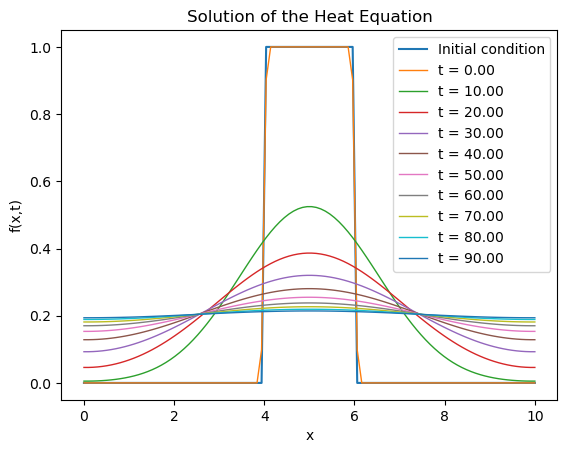

In [8]:
import torch
import matplotlib.pyplot as plt

# Parameters
nx = 100  # Number of spatial points
nt = 10000  # Number of time steps
dx = 10.0 / (nx - 1)  # Spatial step size
dt = 0.01  # Time step size
c = 0.1  # Conduction factor

# Initial condition
x = torch.linspace(0, 10, nx)
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1

# Plot initial condition
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.title('Solution of the Heat Equation')

# Euler method for time integration
for n in range(nt):
    d2f_dx2 = torch.zeros(x.size())
    d2f_dx2[1:-1] = (f[2:] - 2 * f[1:-1] + f[:-2]) / dx**2
    d2f_dx2[0] = d2f_dx2[1] # nothing leaves left of 0
    d2f_dx2[-1] = d2f_dx2[-2] # nothing leaves right of 10
    
    f = f + c * dt * d2f_dx2

    # Plot every 100 time steps
    if n % 1000 == 0:
        plt.plot(x, f, label=f't = {n*dt:.2f}',linewidth=1)

plt.legend()
plt.show()

## The role of the coefficient c
The coefficient $c$, in this case, represents the energy of the particles (i.e. heat). The more energy, the higher $c$, and the more particules will move between locations. 

We can re-write the code to match the analogy of moving particles.

Considering a location $x$, $f(x,t)$ will decrease if $f(x,t)$ has more particles than $f(x+dx,t)$: in average more particles will leave location $x$ to go to $x+dx$, than the reverse. 

And the number of particles moving will be modulated by the coefficient $c$: the bigger $c$, the more energy, the more particles will move. 

So we can compute how many particles will leave to the right of the location $x$:
$$\text{flux}_\text{right} = c.( f(x,t) - f(x+dx,t) )$$

And similarly, the number of particles leaving towards the left of location $x$:
$$\text{flux}_\text{left} = c.( f(x,t) - f(x-dx,t) )$$

If those fluxes are positives, then $f(x,t)$ will decrease, so:
$$ f(x,t+dt) = f(x,t) - dt. \left( \text{flux}_\text{left} + \text{flux}_\text{right} \right)$$


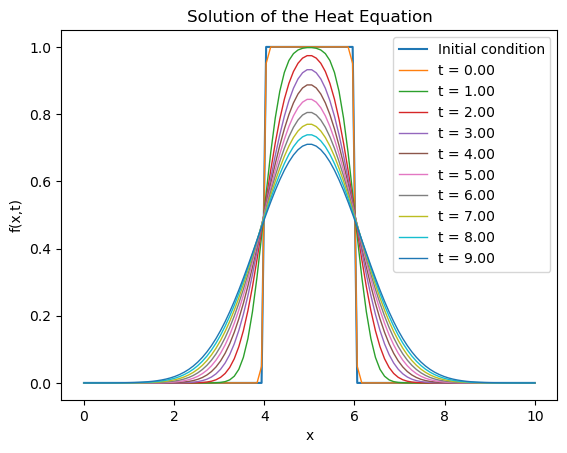

In [10]:
import torch
import matplotlib.pyplot as plt
# Parameters
nx = 100  # Number of spatial points
nt = 1000  # Number of time steps
dx = 10.0 / (nx - 1)  # Spatial step size
dt = 0.01  # Time step size
c = 0.5  # Conduction factor

# Initial condition
x = torch.linspace(0, 10, nx)
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1


# Plot initial condition
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.title('Solution of the Heat Equation')

# Euler method for time integration
for n in range(nt):
    # what leaves on the right
    fluxR = torch.zeros(x.size())
    fluxR[:-1] = c*(f[:-1] - f[1:]) / dx
    # what leaves on the left
    fluxL = torch.zeros(x.size())
    fluxL[1:]  = c*(f[1:] - f[:-1]) / dx
    # update the central location: if above is positive, particles are leaving
    f = f - dt * (fluxR+fluxL)
        
    # Plot every 100 time steps
    if n % (nt/10) == 0:
        plt.plot(x, f, label=f't = {n*dt:.2f}',linewidth=1)

plt.legend()
plt.show()

Because random motion is averaged over time, it is very good for reducing noise. As good as blurring with Gaussian kernel.

We can see that by adding noise in the orginal signal and running the simulation again


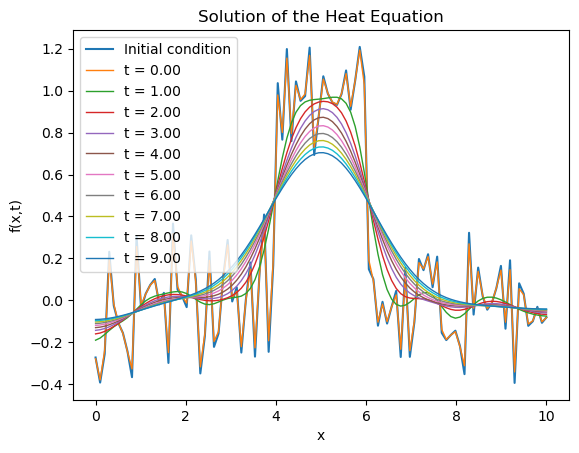

In [12]:
import torch
import matplotlib.pyplot as plt
# Parameters
nx = 100  # Number of spatial points
nt = 1000  # Number of time steps
dx = 10.0 / (nx - 1)  # Spatial step size
dt = 0.01  # Time step size
c = 0.5  # Conduction factor

# Initial condition
x = torch.linspace(0, 10, nx)
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1

#f += 0.2*np.random.randn(f.shape[0])
f += 0.2*torch.randn(f.shape[0])

# Plot initial condition
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.title('Solution of the Heat Equation')

# Euler method for time integration
for n in range(nt):
    # what leaves on the right
    fluxR = torch.zeros(x.size())
    fluxR[:-1] = c*(f[:-1] - f[1:]) / dx
    # what leaves on the left
    fluxL = torch.zeros(x.size())
    fluxL[1:]  = c*(f[1:] - f[:-1]) / dx
    # update the central location: if above is positive, particles are leaving
    f = f - dt * (fluxR+fluxL)
        
    # Plot every 100 time steps
    if n % (nt/10) == 0:
        plt.plot(x, f, label=f't = {n*dt:.2f}',linewidth=1)

plt.legend()
plt.show()

## Anisotropic diffusion

One issue is that the whole signal gets blurred. It would be good to blurr only the flat areas, and keep the large edges from the signal untouched. 

This can be done using the conduction coefficient: we can make c to be large where the signal is flat, and small where there is an edge. In other words, make c a function of the gradient of the signal. This is called anisotripic diffusion and there are many versions of how to compute $c(x)$. Let try with a simple function for c depending on the signal gradient: 

$$ c(x) = \frac{1}{1 + \frac{1}{K}.\frac{\partial f(x,t)}{\partial x}}$$    

- if the first derivative $\frac{\partial f(x,t)}{\partial x}$ is large (compare to K), then $c(x)$ becomes small so slow down the motion of particle. This is a case with a big edge.
- if the first derivative is small (compare to K), then $c(x)$ becomes close to 1 and the normal motion occurs

In other words, the motion of particles is slowed down across big edges

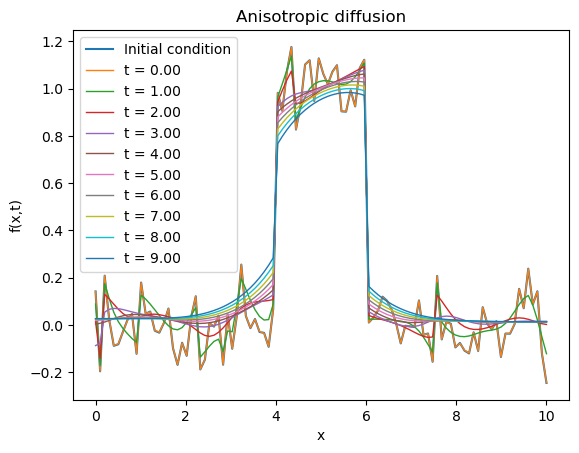

In [14]:
import torch
import matplotlib.pyplot as plt
# Parameters
nx = 100  # Number of spatial points
nt = 1000  # Number of time steps
dx = 10.0 / (nx - 1)  # Spatial step size
dt = 0.01  # Time step size
c = 0.5  # Conduction factor
K = 0.2 # edge threshold

# Initial condition
x = torch.linspace(0, 10, nx)
f = torch.zeros(x.size())
f[(x >= 4) & (x <= 6)] = 1

f += 0.1*torch.randn(f.shape[0])

# Plot initial condition
plt.plot(x, f, label='Initial condition')
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.title('Anisotropic diffusion')

# Function to compute the diffusion coefficient
def diffusion_coefficient(df_dx, K):
    return 1.0 / (1.0 + (df_dx / K)**2)

# Euler method for time integration
for n in range(nt):
    # right derivative
    df_dxR = torch.zeros(x.size())
    df_dxR[:-1] = (f[:-1] - f[1:]) / dx
    # left derivative
    df_dxL = torch.zeros(x.size())
    df_dxL[1:]  = (f[1:] - f[:-1]) / dx
    # total derivatives
    df_dx = (df_dxR + df_dxL)/2
    # compute c as a function of the first derivative
    c = diffusion_coefficient(df_dx, K)
    # update the fluxes
    fluxR = c*df_dxR
    fluxL = c*df_dxL
    
    # update the central location: if flux is positive, particles are leaving
    f = f - dt * (fluxR+fluxL)
        
    # Plot every 100 time steps
    if n % (nt/10) == 0:
        plt.plot(x, f, label=f't = {n*dt:.2f}',linewidth=1)

plt.legend()
plt.show()

This is the publication for reference: Perona, Pietro, and Jitendra Malik. "Scale-space and edge detection using anisotropic diffusion." IEEE Transactions on pattern analysis and machine intelligence 12.7 (1990): 629-639

In that paper, the application was image denoising. It is straightforward to implement the diffusion equation in more than 1 dimension. Here we extend it to images in 2D. 

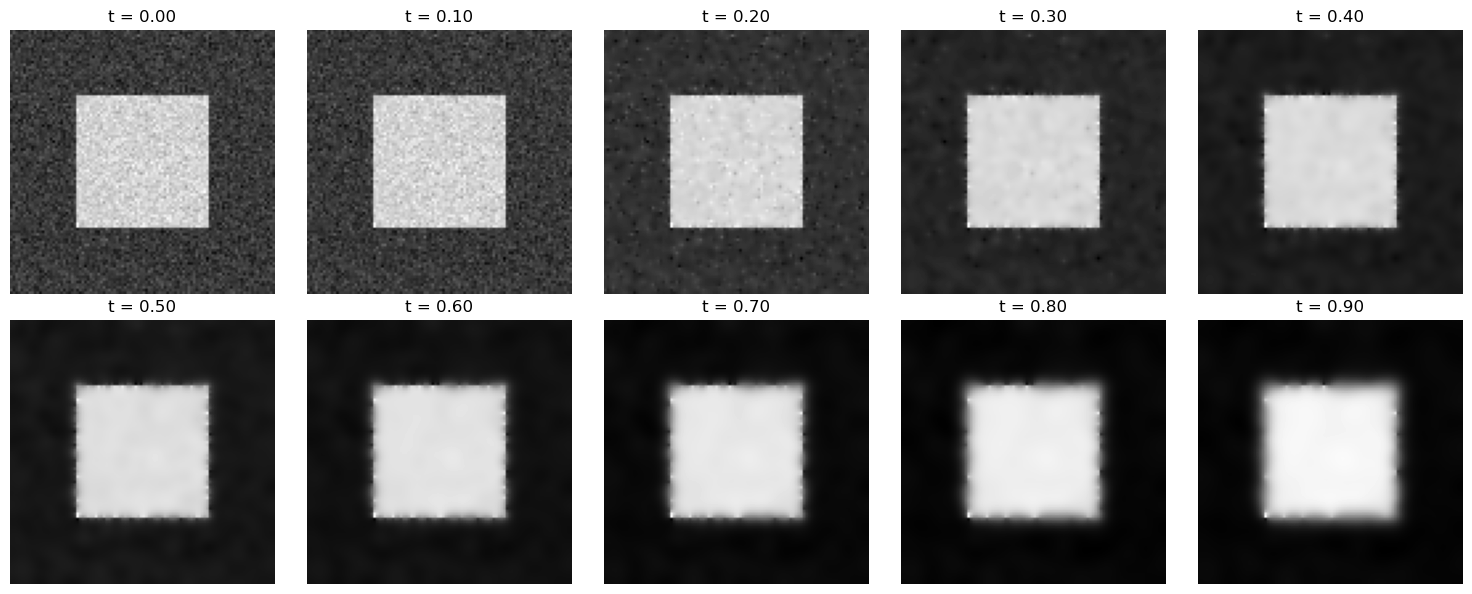

In [16]:
import torch
import matplotlib.pyplot as plt

# Parameters
nx, ny = 100, 100  # Number of spatial points in x and y directions
nt = 100  # Number of time steps
dx, dy = 1.0, 1.0  # Spatial step sizes
dt = 0.1  # Smaller time step size for stability
K = 0.1  # Adjusted gradient threshold parameter

# Create a sample initial image with a square in the middle
image = torch.zeros((nx, ny))
image[nx//4:3*nx//4, ny//4:3*ny//4] = 1

# Add some noise to the image
noise = 0.1 * torch.randn(image.size())
image += noise

# Function to compute the diffusion coefficient
def diffusion_coefficient(grad_x, grad_y, K):
    grad_magnitude_squared = grad_x**2 + grad_y**2
    return 1.0 / (1.0 + grad_magnitude_squared / K**2)

# Store images at each time step
images = [image.clone()]  # Store initial image

# Anisotropic diffusion process
for n in range(nt):

    # right derivative along x
    gradxR = torch.zeros(image.size())
    gradxR[:-1,:] = (image[:-1,:] - image[1:,:]) / dx
    # left derivative along x
    gradxL = torch.zeros(image.size())
    gradxL[1:,:]  = (image[1:,:] - image[:-1,:]) / dx

    # right derivative along y
    gradyR = torch.zeros(image.size())
    gradyR[:,:-1] = (image[:,:-1] - image[:,1:]) / dx
    # left derivative along y
    gradyL = torch.zeros(image.size())
    gradyL[:,1:]  = (image[:,1:] - image[:,:-1]) / dx

    # combine the derivativs
    gradx = 0.5*(gradxR+gradxL)
    grady = 0.5*(gradyR+gradyL)
    
    # Compute the diffusion coefficient
    c = diffusion_coefficient(gradx, grady, K)

    # Update the image
    image = image - dt * c * 2 * (gradx+grady)

    # Store 10 images along the simulation 
    if n % (nt/10) == 0:
        images.append(image.clone())

# Plot the grid of images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f't = {i*dt:.2f}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


if it runs for too long, eventually the edges will blurred since $c(x)$ is never 0. But this technique allows to remove noise without blurring too much the actual signal as seen at time t=0.3 in the above.

And this is how painting effect is implemented in software like Photoshop. For going deeper into difusion filtering, this reference is good: https://nils-olovsson.se/articles/image_smearing_by_anisotropic_diffusion/

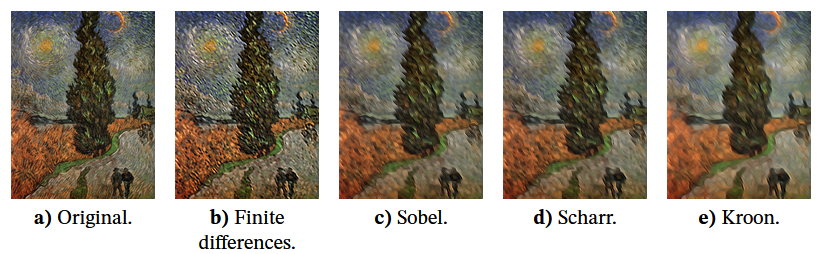


## bonus: make a gif

We can make a movie of the diffusion, which is very handy to show time evolution of a process

In [50]:
import gif # might require to run 'pip install gif'

# set resolution
gif.options.matplotlib["dpi"] = 100

# Decorate a plot function with @gif.frame
@gif.frame
def plot(im):
    plt.imshow(im,cmap='gray')
    plt.axis('off')

# Construct "frames"
frames = [plot(im) for im in images]

# Save "frames" to gif with a specified duration (milliseconds) between each frame
gif.save(frames, 'AnisotropicDiffusion.gif', duration=500)


done


Try on a real image

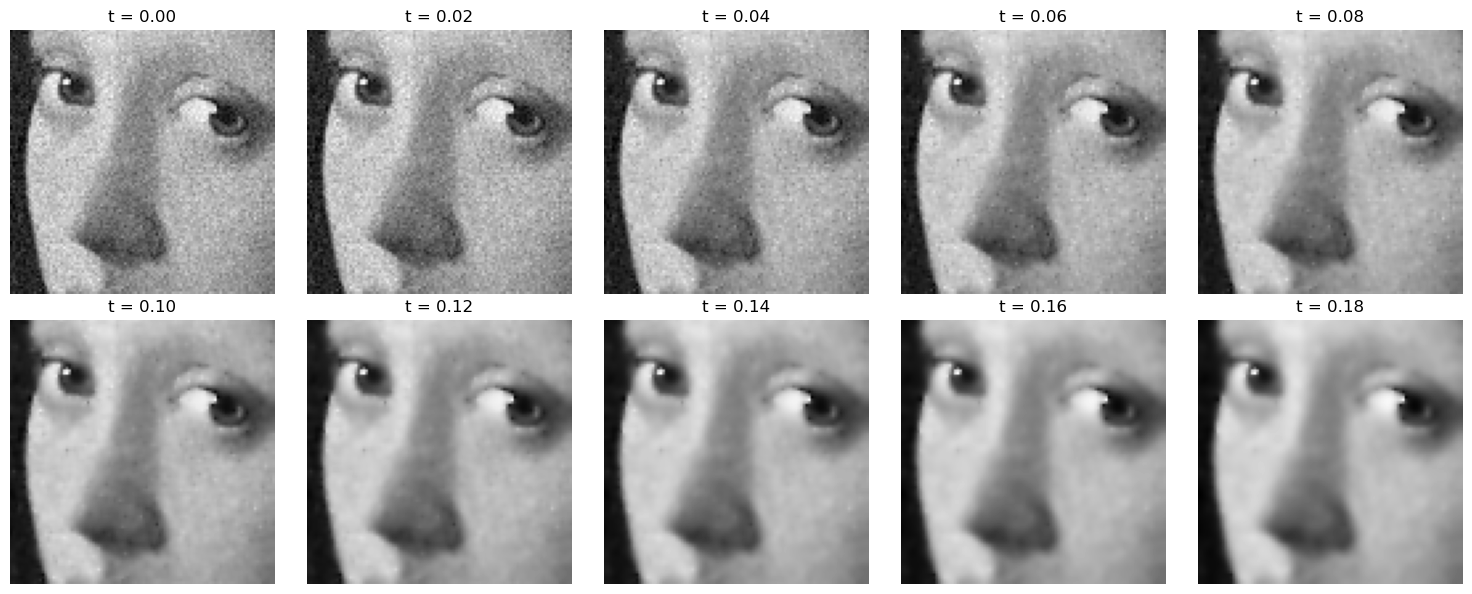

In [128]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# Parameters
nx, ny = 100, 100  # Number of spatial points in x and y directions
nt = 100  # Number of time steps
dx, dy = 1.0, 1.0  # Spatial step sizes
dt = 0.02  # Smaller time step size for stability
K = 0.1  # Adjusted gradient threshold parameter

# Create a sample initial image with a square in the middle
image = mpimg.imread('500px-1665_Girl_with_a_Pearl_Earring.jpg')
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
image = torch.tensor(rgb2gray(image/255))
# crop to see better
image = image[200:300,150:250]

# Add some noise to the image
noise = 0.05 * torch.randn_like(image)
image += noise

# Function to compute the diffusion coefficient
def diffusion_coefficient(grad_x, grad_y, K):
    grad_magnitude_squared = grad_x**2 + grad_y**2
    return 1.0 / (1.0 + grad_magnitude_squared / K**2)

# Store images at each time step
images = [image.clone()]  # Store initial image

# Anisotropic diffusion process
for n in range(nt):

    # right derivative along x
    gradxR = torch.zeros(image.size())
    gradxR[:-1,:] = (image[:-1,:] - image[1:,:]) / dx
    # left derivative along x
    gradxL = torch.zeros(image.size())
    gradxL[1:,:]  = (image[1:,:] - image[:-1,:]) / dx

    # right derivative along y
    gradyR = torch.zeros(image.size())
    gradyR[:,:-1] = (image[:,:-1] - image[:,1:]) / dx
    # left derivative along y
    gradyL = torch.zeros(image.size())
    gradyL[:,1:]  = (image[:,1:] - image[:,:-1]) / dx

    # combine the derivativs
    gradx = 0.5*(gradxR+gradxL)
    grady = 0.5*(gradyR+gradyL)
    
    # Compute the diffusion coefficient
    c = diffusion_coefficient(gradx, grady, K)

    # Update the image
    image = image - dt * c * 2 * (gradx+grady)

    # Store 10 images along the simulation 
    if n % (nt/10) == 0:
        images.append(image.clone())

# Plot the grid of images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f't = {i*dt:.2f}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


import gif # might require to run 'pip install gif'

# set resolution
gif.options.matplotlib["dpi"] = 100

# Decorate a plot function with @gif.frame
@gif.frame
def plot(im):
    plt.imshow(im,cmap='gray')
    plt.axis('off')

# Construct "frames"
frames = [plot(im) for im in images]

# Save "frames" to gif with a specified duration (milliseconds) between each frame
gif.save(frames, 'GWTPEdiffusion.gif', duration=500)